In [1]:
from ase.io import read
from pathlib import Path
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
from pymatgen.io.vasp import Vasprun
import numpy as np

import plotting


minirun_path = Path('/u/twarford/isambard/dft/minirun/R2SCAN_dipole')
atoms_list = read('mace-mh-1.xyz', ':')

In [2]:
atoms_list_tested = []

for atoms in atoms_list:
    if (minirun_path/atoms.info['oc_id']).exists():
        atoms_list_tested.append(atoms)

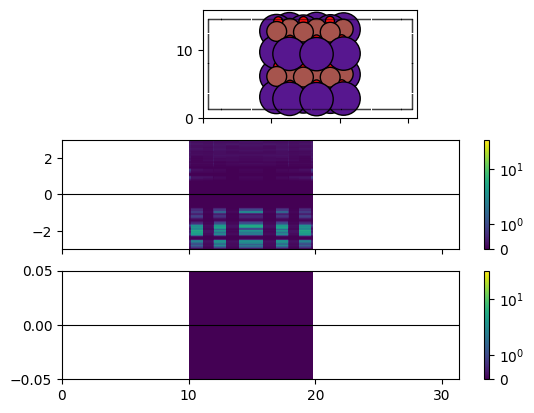

In [3]:
# test cell
vr = Vasprun("/raven/ptmp/twarford/jfremote_workdirs/prod0/07/81/db/0781dbca-43ee-4817-a2f2-8aa0335ff686_1/vasprun.xml.gz", parse_dos=True, parse_potcar_file=False)

atoms = plotting.vasprun_to_atoms_with_pdos(vr)

fig, ax = plt.subplots(3, 1, sharex=True)
ax[0] = plot_atoms(atoms, ax[0], rotation=('0x, 90y, 0z'), )#show_unit_cell=1)
atoms_z = atoms.get_positions()[:, 2]
ax[1] = plotting.plot_site_dos_heatmap(atoms, ax=ax[1])
ax[2] = plotting.plot_site_dos_heatmap(atoms, ax=ax[2], e_max=0.05)

In [4]:
isambard_path = Path("/u/twarford/ptmp_link")
out_path = Path("oc20_sample_plots_log_cbar"); out_path.mkdir(exist_ok=True)
worst_10 = []
best_10 = []

for i, atoms in enumerate(atoms_list_tested):
    vasp_dir_path = Path(read(minirun_path/atoms.info['oc_id']/'labels.xyz.gz', 0).info['vasp_dir_name'])
    idx = vasp_dir_path.parts.index("jfremote_workdirs")
    vr_path = isambard_path/Path(*vasp_dir_path.parts[idx:])/'vasprun.xml.gz'


    # print(new_vasp_path)
    # break

    vr = Vasprun(vr_path, parse_dos=True, parse_potcar_file=False)

    atoms = plotting.vasprun_to_atoms_with_pdos(vr)

    fig, ax = plt.subplots(3, 1, sharex=True)
    ax[0] = plot_atoms(atoms, ax[0], rotation=('0x, 90y, 0z'), )#show_unit_cell=1)
    atoms_z = atoms.get_positions()[:, 2]
    ax[1] = plotting.plot_site_dos_heatmap(atoms, ax=ax[1], norm='log')
    ax[2] = plotting.plot_site_dos_heatmap(atoms, ax=ax[2], e_max=0.05, norm='log')

    fig.supxlabel('Density of States')
    fig.supylabel('z')
    fig.savefig(out_path/f"{i}.png")
    break

    if i > 10:
        plt.close()

KeyboardInterrupt: 

In [ ]:
from pymatgen.core import Composition, Element, Structure
# def _get_electronegativity_difference
[el.X for el in Composition(atoms.get_chemical_formula()).elements]

[1, 3.04, 1.9]

PearsonRResult(statistic=np.float64(-0.030062116511391887), pvalue=np.float64(0.24985534383663635))

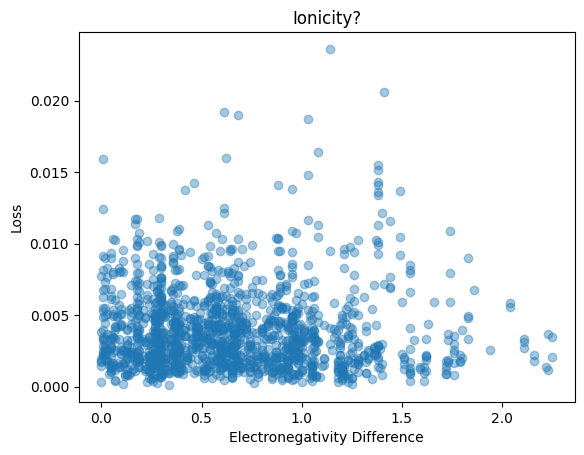

In [ ]:
binary_list = []
ionicity_list = []
loss_list = []
for atoms in atoms_list:
    comp = Composition(atoms.get_chemical_formula()).reduced_composition
    electronegativities = [species.X for species in comp.elements]
    if len(electronegativities) != 2: continue

    ionicity_list.append(np.abs(electronegativities[0] - electronegativities[1]))
    loss_list.append(atoms.info['loss'])
    binary_list.append(atoms)

from scipy.stats import pearsonr

plt.title('Ionicity?')
plt.xlabel('Electronegativity Difference')
plt.ylabel('Loss')
plt.scatter(ionicity_list, loss_list, alpha=0.4)
pearsonr(ionicity_list, loss_list)

In [5]:
import numpy as np
from scipy.stats import ttest_ind

has_n = np.array(["N" in set(a.get_chemical_symbols()) for a in atoms_list])
loss = np.array([a.info["loss"] for a in atoms_list], dtype=float)

mu_n = loss[has_n].mean()
mu_no_n = loss[~has_n].mean()
res = ttest_ind(loss[has_n], loss[~has_n], equal_var=False, alternative="greater")

print(f"E[loss | has N]    = {mu_n:.4f}")
print(f"E[loss | no N]     = {mu_no_n:.4f}")
print(f"Difference (N-noN) = {mu_n - mu_no_n:.4f}")
print(f"one-sided Welch t-test p-value = {res.pvalue:.3g}")

E[loss | has N]    = 0.0071
E[loss | no N]     = 0.0036
Difference (N-noN) = 0.0034
one-sided Welch t-test p-value = 2.71e-40


In [15]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

loss = np.array([a.info["loss"] for a in atoms_list], dtype=float)
elements = sorted({el for a in atoms_list for el in set(a.get_chemical_symbols())})

rows = []
for el in elements:
    
    has_el = np.array([el in set(a.get_chemical_symbols()) for a in atoms_list])
    x, y = loss[has_el], loss[~has_el]
    if len(x) < 2 or len(y) < 2:
        continue
    res = ttest_ind(x, y, equal_var=False, alternative="greater")
    rows.append({
        "element": el,
        "n_has": len(x),
        "n_no": len(y),
        "E[loss|has]": x.mean(),
        "E[loss|no]": y.mean(),
        "diff": x.mean() - y.mean(),
        "pvalue": res.pvalue,
        "X": Element(el).X,
    })

df = pd.DataFrame(rows).sort_values("pvalue")
df["p<0.01"] = df["pvalue"] < 0.01

display(
    df.style.format({
        "E[loss|has]": "{:.4f}",
        "E[loss|no]": "{:.4f}",
        "diff": "{:.4f}",
        "pvalue": "{:.3g}",
    }).apply(
        lambda r: ["background-color: #ffe6e6" if r["p<0.01"] else "" for _ in r],
        axis=1
    )
)

,element,n_has,n_no,E[loss|has],E[loss|no],diff,pvalue,X,p<0.01
24,N,319,5341,0.0071,0.0036,0.0034,2.71e-40,3.040000,True
10,Cr,222,5438,0.0063,0.0037,0.0026,1.72e-28,1.660000,True
29,P,405,5255,0.0053,0.0037,0.0016,8.04e-25,2.190000,True
13,Fe,330,5330,0.0053,0.0037,0.0016,3.87e-20,1.830000,True
22,Mn,317,5343,0.0054,0.0037,0.0017,8.8e-20,1.550000,True
41,Si,551,5109,0.0047,0.0037,0.0009,2.85e-19,1.900000,True
23,Mo,198,5462,0.0058,0.0038,0.0021,4.43e-18,2.160000,True
26,Nb,272,5388,0.0048,0.0038,0.0010,8.1e-14,1.600000,True
5,C,66,5594,0.0062,0.0038,0.0024,5.2e-10,2.550000,True
44,Ta,188,5472,0.0050,0.0038,0.0012,1.82e-09,1.500000,True


In [ ]:
def get_dipole_guess(atoms, fast=True):
    positions = atoms.get_positions()

    struct = Structure.from_ase_atoms(atoms)

    if fast:
        reduced_composition = struct.composition.reduced_composition
        oxi_guess = reduced_composition.oxi_state_guesses()
        oxi_guess = oxi_guess or [{e.symbol: 0 for e in reduced_composition}]  # type:ignore[assignment]
        struct.add_oxidation_state_by_element(oxi_guess[0])
    else:
        struct.add_oxidation_state_by_guess()

    charges = np.array([a.specie.oxi_state for a in struct.sites])

    return (positions * charges[:, None]).sum(axis=0)

  0%|          | 0/5660 [00:00<?, ?it/s]

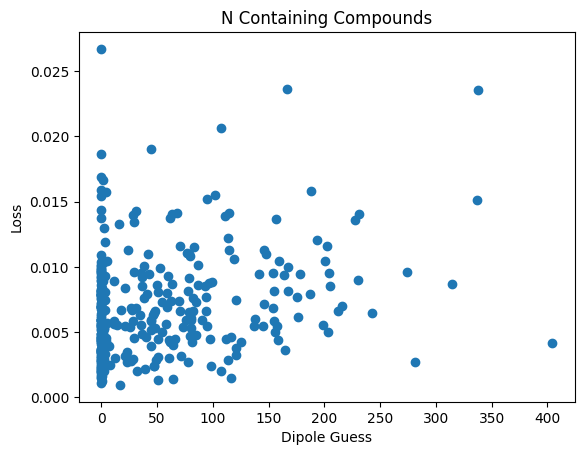

In [ ]:
from tqdm.auto import tqdm

atoms_list_n = []
loss_n = []
dipole_z_guess_n = []

for atoms in tqdm(atoms_list):
    has_n = "N" in set(atoms.get_chemical_symbols())
    if has_n:
        dipole_z_guess =  get_dipole_guess(atoms)[2]
        atoms.info['dipole_z_guess'] = dipole_z_guess
        loss_n.append(atoms.info['loss'])
        dipole_z_guess_n.append(np.abs(dipole_z_guess))

plt.title('N Containing Compounds')
plt.xlabel('Dipole Guess')
plt.ylabel('Loss')
plt.scatter(dipole_z_guess_n, loss_n)

In [7]:
pearsonr(dipole_z_guess_n, loss_n)
# high dipole -> unlikely to have low loss

NameError: name 'pearsonr' is not defined

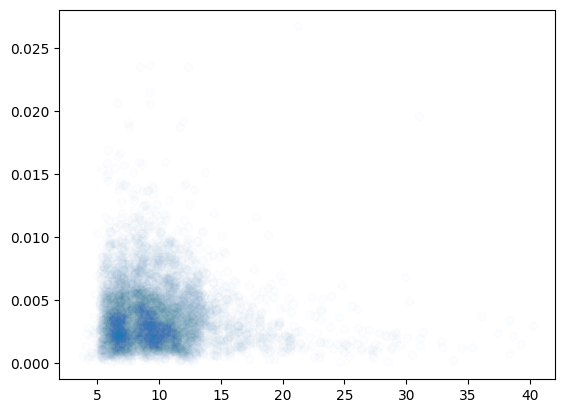

In [8]:
from tqdm.auto import tqdm

loss= []
loss_per_atom = []
thickness = []

def get_slab_thickness(atoms):
    z_pos = atoms.get_positions()[:, 2]
    return max(z_pos) - min(z_pos)

for atoms in atoms_list:
    loss.append(atoms.info['loss'])
    loss_per_atom.append(atoms.info['loss']/len(atoms))
    thickness.append(get_slab_thickness(atoms))



plt.scatter(thickness, loss, alpha=0.01)

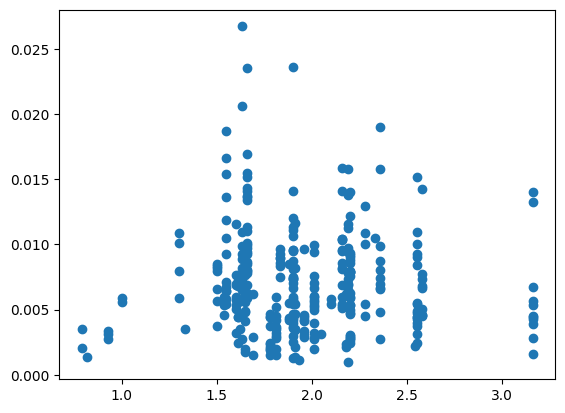

In [13]:
from pymatgen.core import Element
from ase.io import write

n_atoms_list = []
n_loss_list = []
highest_x_list = []
diff_x_list = []

for atoms in atoms_list:
    elements = set(atoms.get_chemical_symbols())
    if ('N' in elements):
        n_atoms_list.append(atoms)
        n_loss_list.append(atoms.info['loss'])
        elements.remove('N')
        highest_x = max(Element(el).X for el in elements)

        

        highest_x_list.append(highest_x)
        diff_x_list.append(3.04 - highest_x)

plt.scatter(highest_x_list, n_loss_list)

write('n_containing.xyz', n_atoms_list)

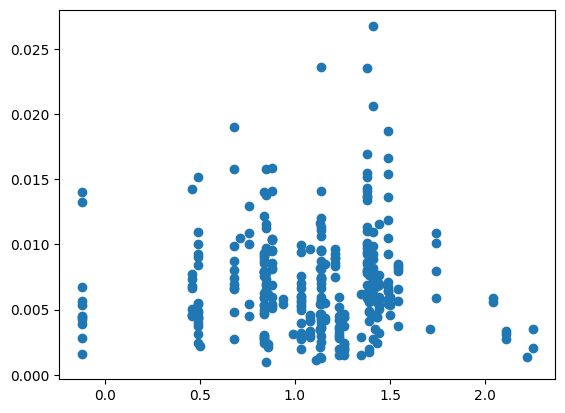

In [14]:
plt.scatter(diff_x_list, n_loss_list)
